In [1]:
import sys
import numpy as np

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmda/testing', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import pickle
from importlib import reload
import numpy as np

In [3]:
# Load state sequence and data from the pickle file
with open('/Users/david/Documents/mastersCode/ubm/final/tests/train-test-val.pkl', 'rb') as file:
    loaded_train_test_val = pickle.load(file)

# Access the loaded data
# loaded_ss = loaded_data['state_sequence']
# loaded_data = loaded_data['data']

In [4]:
from final.useful import *

In [5]:
nfft = 128 # 64 # 32
labels = np.unique(loaded_train_test_val['train'].sample_labels)
# get_log_power_feature()

In [6]:
train_labels = loaded_train_test_val['train'].sample_labels
train_samples = loaded_train_test_val['train'].samples
humpback_indices = train_labels == 0
train_samples_humpback = [item for item, condition in zip(train_samples, humpback_indices) if condition]


In [7]:
def get_feature(sample, nfft):
    feat = np.log(np.square(np.abs(librosa.stft(sample, n_fft=nfft)).T))
    return feat

In [8]:
train_features_humpback = []
for sample in train_samples_humpback:
    train_features_humpback.append(get_feature(sample, nfft))

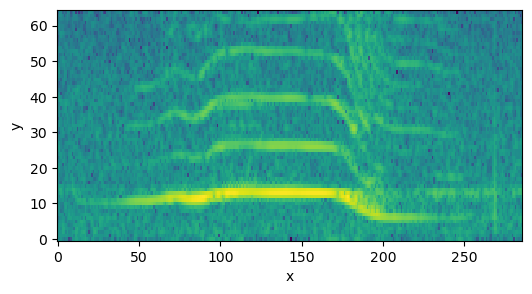

In [9]:
vis_helper(train_features_humpback[0])

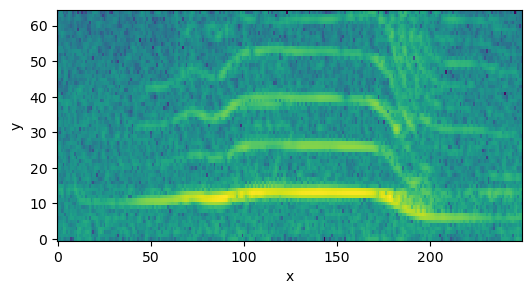

In [10]:
train_features_humpback_concat = np.concatenate(train_features_humpback)
smaller_features = train_features_humpback_concat[:250,:]
np.min(smaller_features)
vis_helper(smaller_features)

sbp_prior


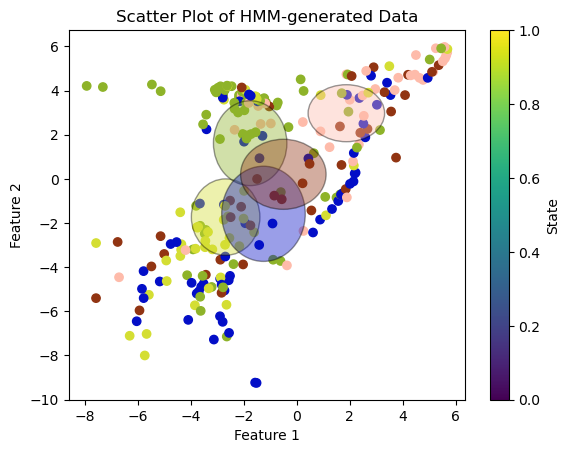

In [30]:
import final.models.hdphmm.hdphmmda.hdp_hmm_da as hdp_hmm_da
reload(hdp_hmm_da)
import final.models.hdphmm.hdphmmda.hdp_hmm_da_utils.utils as utils
reload(utils)
from final.models.hdphmm.hdphmmda.hdp_hmm_da_utils.hdp_hmm_da_consts import *
sbp = {
    GAMMA0: 10,
    ALPHA0: 100,
    KAPPA0: 5,
}
sbp[RHO0] = sbp[KAPPA0] / ( sbp[KAPPA0] + sbp[ALPHA0])
temp = 1

hdp_hmm = hdp_hmm_da.InfiniteDirectSamplerHMM(smaller_features, 5, Z_true=None, iterations=40, verbose=True, sbp=sbp, temp=1)

import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)

plot_hmm.plot_hmm_data(smaller_features, hdp_hmm.Z, hdp_hmm.K, hdp_hmm.hmm.means_, hdp_hmm.hmm.covars_, feature_a=11, feature_b=12)

# plt.scatter(pca_features[:, 0], pca_features[:, 5], c=hdp_hmm.Z, cmap='viridis', marker='o')

In [31]:
hdp_hmm.fit()

warning self.nk == nk) != True:
it:  0  --  3.510218858718872
it:  1  --  3.595315933227539
it:  2  --  3.4151408672332764


KeyboardInterrupt: 

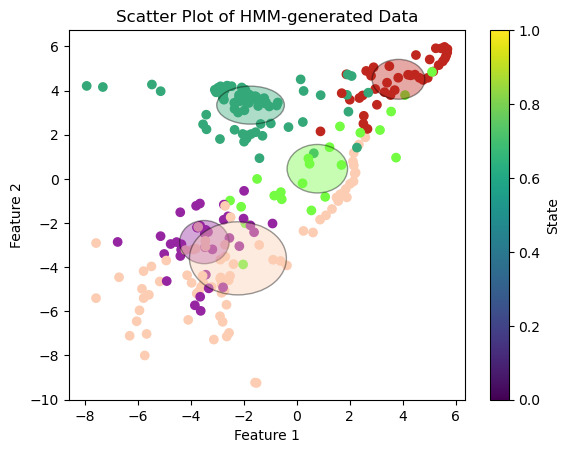

In [21]:
plot_hmm.plot_hmm_data(smaller_features, hdp_hmm.Z, hdp_hmm.K, hdp_hmm.hmm.means_, hdp_hmm.hmm.covars_, feature_a=11, feature_b=12)

In [20]:
np.mean(hdp_hmm.track[TIME])

3.2141662538051605